# Word Level Federated Text Generation with Stack Overflow with Randomly Initialized or Pretrained Word Embeddings
- Joel Stremmel
- 02-20-20
- Runs on GCP and local Ubuntu 16.04

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is initialized with one of the following options by setting the `EMBEDDING_LAYER` parameter:
- [GloVe](https://nlp.stanford.edu/projects/glove/) ([license here](https://www.opendatacommons.org/licenses/pddl/1.0/))
- [FastText](https://fasttext.cc/docs/en/english-vectors.html) ([license here](https://creativecommons.org/licenses/by-sa/3.0/))
- [GPT-2](https://openai.com/blog/better-language-models/) ([license here](https://github.com/huggingface/transformers/blob/master/LICENSE))
- [Randomly initialized embeddings](https://www.tensorflow.org/api_docs/python/tf/random_uniform_initializer)  

After downloading the GloVe or FastText embeddings, place the embedding files at the top level of the repository in directories called `word_embedding/glove` and `word_embedding/fasttext` respectively.  GPT-2 embeddings are downloaded by running the notebook which makes a call to `src/embeddings.py` to download the embeddings from [huggingface](https://github.com/huggingface/transformers).  

**Code from Tensorflow Federated:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data and Model References:**
- [TFF Stack Overflow `load_data`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data)
- [TFF text generation tutorial](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb)
- [Google TFF team research baselines for Stack Overflow](https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow)
- [Tensorflow text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

**Environment Setup References:**
- [Installing Tensorflow for GPU](https://www.tensorflow.org/install/gpu)
- [Install CUDA 10.0 and cuDNN v7.4.2 on Ubuntu 16.04](https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d)
- [Tensorflow build configs](https://www.tensorflow.org/install/source#tested_build_configurations)
- [Using jupyter notebooks with a virtual environment](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)

### Imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [4]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

### Set Some Parameters for Preprocessing the Data and Training the Model

In [5]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 60
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 100
RNN_UNITS = 256

EMBEDDING_LAYER = 'gpt2'
SAV = 'embedding_layer_results/{}_{}_{}_{}/'.format(EMBEDDING_LAYER, 
                                                    EMBEDDING_DIM, 
                                                    RNN_UNITS, 
                                                    EMBEDDING_DIM)

### Create the Output Directory if it Nonexistent

In [6]:
if not os.path.exists(SAV):
    os.makedirs(SAV)

### Load and Preprocess Word Level Datasets

In [7]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [8]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Set Extended Vocab Size
We account for the following four special tokens applied during preprocessing with `construct_word_level_datasets`:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [9]:
extended_vocab_size = VOCAB_SIZE + len(dataset.get_special_tokens(VOCAB_SIZE))

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If the `EMBEDDING_LAYER` option is set to 'random', the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.  Otherwise, an embedding index called `word2embedding` is created from pretrained embeddings either loaded from the 'word_embeddings' directory or created from a pretrained model.

In [10]:
if EMBEDDING_LAYER == 'random':
    pass

elif EMBEDDING_LAYER == 'glove':
    embedding_path = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-{}d-1M.vec'.format(EMBEDDING_DIM)
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pca_projections(word2embedding, n=EMBEDDING_DIM)
    
else:
    raise ValueError("EMBEDDING LAYER must be one of 'random', 'glove', 'fasttext', or 'gpt2'.")

In [11]:
if EMBEDDING_LAYER == 'random':
    embedding_matrix = 'uniform'
else:
    embedding_matrix = embeddings.create_matrix_from_pretrained_embeddings(
        word2embedding=word2embedding,
        embedding_dim=EMBEDDING_DIM,
        vocab=vocab)

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:79: missing_words_warning: 5 words set to default random initialization
  .format(missing), missing_words_warning)


### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [12]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [13]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [14]:
tff.framework.set_default_executor(tff.framework.local_executor_factory(max_fanout=10))

### Create an Iterative Process

In [15]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=extended_vocab_size,
                                           embedding_dim=EMBEDDING_DIM,
                                           embedding_matrix=embedding_matrix,
                                           rnn_units=RNN_UNITS,
                                           vocab_size=VOCAB_SIZE,
                                           sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          #client_optimizer_fn=federated.client_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/learning/federated_averaging.py:242: UserWarning: tff.learning.build_federated_averaging_process will start requiring a new argument 'client_optimizer_fn'. Specify the local client optimizer here rather than building a ttf.learning.TrainableModel
  warnings.warn('tff.learning.build_federated_averaging_process will start '


### Initalize the Process
Server state will be updated in the training loop.

In [16]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [17]:
for round_num in range(0, NUM_ROUNDS):

    # Examine validation metrics
    print('Evaluating before round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
    validation.keras_evaluate(state=server_state,
                              val_dataset=val_data,
                              extended_vocab_size=extended_vocab_size,
                              vocab_size=VOCAB_SIZE,
                              embedding_dim=EMBEDDING_DIM,
                              embedding_matrix=embedding_matrix,
                              rnn_units=RNN_UNITS,
                              metrics_tracker=val_metrics_tracker)

    # Sample train clients to create a train dataset
    print('Sampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
    train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)

    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
    train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
    train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
    train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
    # Save loss and accuracy from train and validation sets
    np.save(SAV + 'train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
    np.save(SAV + 'val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
    # Save train sample stats
    np.save(SAV + 'num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
    np.save(SAV + 'num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
    np.save(SAV + 'num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))

Evaluating before round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 123ms/step - loss: 6.5678 - num_tokens: 135725.0000 - num_tokens_no_oov: 130958.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 4.9365e-04 - accuracy_no_oov: 5.1161e-04 - accuracy_no_oov_no_eos: 5.4130e-04Sampling 10 new clients.
Round: 0
   Loss: 7.68516588
   num_batches: 179
   num_examples: 2788
   num_tokens: 35707
   num_tokens_no_oov: 34515
   accuracy: 0.00076
   accuracy_no_oov: 0.00070
Evaluating before round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 129ms/step - loss: 6.4731 - num_tokens: 133531.0000 - num_tokens_no_oov: 129338.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 9.2113e-04 - accuracy_no_oov: 9.5100e-04 - accuracy_no_oov_no_eos: 9.9210e-04Sampling 10 new clients.
Round: 1
   Loss: 5.52329636
   num_batches: 421
   num_examples: 6667
   num_tokens: 89788
   num_tokens_no_oov: 87558
   accuracy: 0.01769
   accuracy_no_oov: 0.01814
Evaluating before round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 121ms/step - loss: 6.5561 - num_tokens: 135585.0000 - num_tokens_no_oov: 130795.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0036 - accuracy_no_oov: 0.0037 - accuracy_no_oov_no_eos: 0.0039Sampling 10 new clients.
Round: 2
   Loss: 6.80305290
   num_batches: 215
   num_examples: 3346
   num_tokens: 44237
   num_tokens_no_oov: 42805
   accuracy: 0.00016
   accuracy_no_oov: 0.00016
Evaluating before round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 122ms/step - loss: 6.6340 - num_tokens: 137632.0000 - num_tokens_no_oov: 132920.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0012 - accuracy_no_oov: 0.0013 - accuracy_no_oov_no_eos: 0.0014Sampling 10 new clients.
Round: 3
   Loss: 7.01340294
   num_batches: 141
   num_examples: 2197
   num_tokens: 29130
   num_tokens_no_oov: 28117
   accuracy: 0.00007
   accuracy_no_oov: 0.00007
Evaluating before round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 122ms/step - loss: 6.2277 - num_tokens: 128521.0000 - num_tokens_no_oov: 124551.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.5562e-04 - accuracy_no_oov: 1.6058e-04 - accuracy_no_oov_no_eos: 1.4534e-04Sampling 10 new clients.
Round: 4
   Loss: 6.69415426
   num_batches: 172
   num_examples: 2673
   num_tokens: 33308
   num_tokens_no_oov: 32266
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #5 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 128ms/step - loss: 5.8571 - num_tokens: 120985.0000 - num_tokens_no_oov: 117502.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 3.3062e-05 - accuracy_no_oov: 3.4042e-05 - accuracy_no_oov_no_eos: 1.8196e-05Sampling 10 new clients.
Round: 5
   Loss: 6.00959969
   num_batches: 223
   num_examples: 3488
   num_tokens: 43654
   num_tokens_no_oov: 42628
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #6 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 123ms/step - loss: 6.2822 - num_tokens: 132046.0000 - num_tokens_no_oov: 128001.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.2719e-05 - accuracy_no_oov: 2.3437e-05 - accuracy_no_oov_no_eos: 8.2988e-06Sampling 10 new clients.
Round: 6
   Loss: 5.67439318
   num_batches: 330
   num_examples: 5180
   num_tokens: 71535
   num_tokens_no_oov: 69561
   accuracy: 0.00155
   accuracy_no_oov: 0.00160
Evaluating before round #7 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 122ms/step - loss: 6.1951 - num_tokens: 133837.0000 - num_tokens_no_oov: 129655.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 7
   Loss: 5.83350849
   num_batches: 225
   num_examples: 3534
   num_tokens: 48092
   num_tokens_no_oov: 46212
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #8 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 130ms/step - loss: 5.8926 - num_tokens: 130537.0000 - num_tokens_no_oov: 126622.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 8
   Loss: 5.99208021
   num_batches: 180
   num_examples: 2819
   num_tokens: 38629
   num_tokens_no_oov: 37515
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #9 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 5.5410 - num_tokens: 126120.0000 - num_tokens_no_oov: 122048.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 9
   Loss: 5.70430660
   num_batches: 199
   num_examples: 3136
   num_tokens: 43960
   num_tokens_no_oov: 42378
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #10 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 126ms/step - loss: 5.6174 - num_tokens: 132974.0000 - num_tokens_no_oov: 128581.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 10
   Loss: 5.52774906
   num_batches: 234
   num_examples: 3652
   num_tokens: 48710
   num_tokens_no_oov: 47362
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #11 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 5.5124 - num_tokens: 134588.0000 - num_tokens_no_oov: 130636.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 11
   Loss: 5.30105782
   num_batches: 202
   num_examples: 3127
   num_tokens: 39728
   num_tokens_no_oov: 38714
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #12 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 124ms/step - loss: 5.2471 - num_tokens: 131692.0000 - num_tokens_no_oov: 127683.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 12
   Loss: 5.43818617
   num_batches: 160
   num_examples: 2498
   num_tokens: 32325
   num_tokens_no_oov: 31321
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #13 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 5.0811 - num_tokens: 130531.0000 - num_tokens_no_oov: 126272.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 13
   Loss: 5.12318420
   num_batches: 244
   num_examples: 3821
   num_tokens: 52928
   num_tokens_no_oov: 51410
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #14 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 123ms/step - loss: 5.1371 - num_tokens: 135831.0000 - num_tokens_no_oov: 131562.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 14
   Loss: 5.08543682
   num_batches: 341
   num_examples: 5393
   num_tokens: 78098
   num_tokens_no_oov: 75732
   accuracy: 0.01174
   accuracy_no_oov: 0.01211
Evaluating before round #15 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 4.9611 - num_tokens: 132427.0000 - num_tokens_no_oov: 128277.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 15
   Loss: 5.50892019
   num_batches: 120
   num_examples: 1837
   num_tokens: 25131
   num_tokens_no_oov: 24339
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #16 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 124ms/step - loss: 4.9274 - num_tokens: 132178.0000 - num_tokens_no_oov: 128311.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 16
   Loss: 5.01497555
   num_batches: 144
   num_examples: 2231
   num_tokens: 28791
   num_tokens_no_oov: 27959
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #17 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 126ms/step - loss: 4.9660 - num_tokens: 134601.0000 - num_tokens_no_oov: 130434.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 17
   Loss: 5.03839493
   num_batches: 310
   num_examples: 4898
   num_tokens: 72301
   num_tokens_no_oov: 70210
   accuracy: 0.01759
   accuracy_no_oov: 0.01686
Evaluating before round #18 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 124ms/step - loss: 4.9248 - num_tokens: 133973.0000 - num_tokens_no_oov: 129765.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 18
   Loss: 5.34056187
   num_batches: 226
   num_examples: 3587
   num_tokens: 52439
   num_tokens_no_oov: 50653
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #19 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 5.0845 - num_tokens: 138228.0000 - num_tokens_no_oov: 133513.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 19
   Loss: 5.23141289
   num_batches: 91
   num_examples: 1382
   num_tokens: 18583
   num_tokens_no_oov: 18123
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #20 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 126ms/step - loss: 5.0775 - num_tokens: 137709.0000 - num_tokens_no_oov: 132914.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 20
   Loss: 4.79664707
   num_batches: 459
   num_examples: 7269
   num_tokens: 101980
   num_tokens_no_oov: 99017
   accuracy: 0.01281
   accuracy_no_oov: 0.01319
Evaluating before round #21 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 14s 136ms/step - loss: 5.3480 - num_tokens: 145776.0000 - num_tokens_no_oov: 141279.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 21
   Loss: 4.88023281
   num_batches: 305
   num_examples: 4814
   num_tokens: 71368
   num_tokens_no_oov: 69390
   accuracy: 0.03240
   accuracy_no_oov: 0.03058
Evaluating before round #22 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 124ms/step - loss: 4.8591 - num_tokens: 132537.0000 - num_tokens_no_oov: 127989.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 22
   Loss: 5.17931175
   num_batches: 134
   num_examples: 2080
   num_tokens: 29438
   num_tokens_no_oov: 28621
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #23 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 125ms/step - loss: 4.7922 - num_tokens: 132716.0000 - num_tokens_no_oov: 128999.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 23
   Loss: 4.59646416
   num_batches: 280
   num_examples: 4425
   num_tokens: 58259
   num_tokens_no_oov: 56731
   accuracy: 0.00105
   accuracy_no_oov: 0.00108
Evaluating before round #24 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 127ms/step - loss: 4.6098 - num_tokens: 127826.0000 - num_tokens_no_oov: 123666.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 24
   Loss: 4.96968985
   num_batches: 181
   num_examples: 2835
   num_tokens: 39721
   num_tokens_no_oov: 38883
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #25 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 126ms/step - loss: 4.7801 - num_tokens: 133621.0000 - num_tokens_no_oov: 129367.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 25
   Loss: 4.76481819
   num_batches: 166
   num_examples: 2576
   num_tokens: 34226
   num_tokens_no_oov: 33151
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #26 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 4.8322 - num_tokens: 135125.0000 - num_tokens_no_oov: 131314.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 26
   Loss: 5.11280680
   num_batches: 140
   num_examples: 2162
   num_tokens: 30869
   num_tokens_no_oov: 29588
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #27 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 126ms/step - loss: 4.6344 - num_tokens: 130414.0000 - num_tokens_no_oov: 126259.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 27
   Loss: 4.45547724
   num_batches: 111
   num_examples: 1713
   num_tokens: 20504
   num_tokens_no_oov: 19905
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #28 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 4.8128 - num_tokens: 135920.0000 - num_tokens_no_oov: 131476.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 28
   Loss: 4.16246223
   num_batches: 426
   num_examples: 6734
   num_tokens: 90066
   num_tokens_no_oov: 87403
   accuracy: 0.06429
   accuracy_no_oov: 0.06290
Evaluating before round #29 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 4.6944 - num_tokens: 132541.0000 - num_tokens_no_oov: 128429.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 29
   Loss: 4.74978304
   num_batches: 301
   num_examples: 4773
   num_tokens: 69621
   num_tokens_no_oov: 67527
   accuracy: 0.02239
   accuracy_no_oov: 0.02184
Evaluating before round #30 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 124ms/step - loss: 4.7488 - num_tokens: 134327.0000 - num_tokens_no_oov: 130675.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 30
   Loss: 4.52984619
   num_batches: 334
   num_examples: 5269
   num_tokens: 75548
   num_tokens_no_oov: 73327
   accuracy: 0.04309
   accuracy_no_oov: 0.04228
Evaluating before round #31 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 4.6777 - num_tokens: 133256.0000 - num_tokens_no_oov: 129160.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 31
   Loss: 4.71464157
   num_batches: 165
   num_examples: 2562
   num_tokens: 34135
   num_tokens_no_oov: 33251
   accuracy: 0.00021
   accuracy_no_oov: 0.00021
Evaluating before round #32 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 4.6577 - num_tokens: 132685.0000 - num_tokens_no_oov: 128181.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 32
   Loss: 4.60809946
   num_batches: 161
   num_examples: 2491
   num_tokens: 32711
   num_tokens_no_oov: 31892
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #33 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 133ms/step - loss: 4.7200 - num_tokens: 135689.0000 - num_tokens_no_oov: 131081.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 33
   Loss: 4.29497051
   num_batches: 271
   num_examples: 4269
   num_tokens: 56305
   num_tokens_no_oov: 54912
   accuracy: 0.01426
   accuracy_no_oov: 0.01462
Evaluating before round #34 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 127ms/step - loss: 4.6843 - num_tokens: 134917.0000 - num_tokens_no_oov: 130874.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 34
   Loss: 4.10245514
   num_batches: 227
   num_examples: 3568
   num_tokens: 43191
   num_tokens_no_oov: 41954
   accuracy: 0.00072
   accuracy_no_oov: 0.00074
Evaluating before round #35 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 4.6146 - num_tokens: 133174.0000 - num_tokens_no_oov: 129219.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 35
   Loss: 3.86134171
   num_batches: 135
   num_examples: 2085
   num_tokens: 22792
   num_tokens_no_oov: 22183
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #36 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 127ms/step - loss: 4.5226 - num_tokens: 130572.0000 - num_tokens_no_oov: 126094.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 36
   Loss: 4.20704699
   num_batches: 301
   num_examples: 4709
   num_tokens: 63636
   num_tokens_no_oov: 62210
   accuracy: 0.04519
   accuracy_no_oov: 0.04543
Evaluating before round #37 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 133ms/step - loss: 4.7221 - num_tokens: 136223.0000 - num_tokens_no_oov: 132086.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 37
   Loss: 4.14703083
   num_batches: 385
   num_examples: 6089
   num_tokens: 83840
   num_tokens_no_oov: 81575
   accuracy: 0.06986
   accuracy_no_oov: 0.06686
Evaluating before round #38 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 129ms/step - loss: 4.4469 - num_tokens: 129231.0000 - num_tokens_no_oov: 124932.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 38
   Loss: 4.46349907
   num_batches: 137
   num_examples: 2121
   num_tokens: 28026
   num_tokens_no_oov: 27192
   accuracy: 0.00004
   accuracy_no_oov: 0.00000
Evaluating before round #39 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 126ms/step - loss: 4.1246 - num_tokens: 120942.0000 - num_tokens_no_oov: 117641.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 39
   Loss: 4.56196070
   num_batches: 264
   num_examples: 4150
   num_tokens: 58672
   num_tokens_no_oov: 56855
   accuracy: 0.02897
   accuracy_no_oov: 0.02853
Evaluating before round #40 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 134ms/step - loss: 4.5604 - num_tokens: 132733.0000 - num_tokens_no_oov: 128712.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 40
   Loss: 4.30060291
   num_batches: 165
   num_examples: 2553
   num_tokens: 34182
   num_tokens_no_oov: 33240
   accuracy: 0.01536
   accuracy_no_oov: 0.01579
Evaluating before round #41 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 15s 147ms/step - loss: 4.3815 - num_tokens: 128334.0000 - num_tokens_no_oov: 124449.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 41
   Loss: 4.10835505
   num_batches: 151
   num_examples: 2350
   num_tokens: 29001
   num_tokens_no_oov: 28291
   accuracy: 0.00007
   accuracy_no_oov: 0.00007
Evaluating before round #42 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 129ms/step - loss: 4.5489 - num_tokens: 133301.0000 - num_tokens_no_oov: 129271.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 42
   Loss: 4.57870483
   num_batches: 124
   num_examples: 1916
   num_tokens: 26302
   num_tokens_no_oov: 25309
   accuracy: 0.00384
   accuracy_no_oov: 0.00000
Evaluating before round #43 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 123ms/step - loss: 4.4033 - num_tokens: 129621.0000 - num_tokens_no_oov: 125469.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 43
   Loss: 3.95882010
   num_batches: 204
   num_examples: 3175
   num_tokens: 39745
   num_tokens_no_oov: 38376
   accuracy: 0.02139
   accuracy_no_oov: 0.02129
Evaluating before round #44 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 123ms/step - loss: 4.5328 - num_tokens: 133140.0000 - num_tokens_no_oov: 128633.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 44
   Loss: 4.41206741
   num_batches: 223
   num_examples: 3500
   num_tokens: 48511
   num_tokens_no_oov: 47033
   accuracy: 0.02253
   accuracy_no_oov: 0.02320
Evaluating before round #45 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 124ms/step - loss: 4.3173 - num_tokens: 127188.0000 - num_tokens_no_oov: 122674.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 45
   Loss: 4.03609037
   num_batches: 240
   num_examples: 3764
   num_tokens: 47184
   num_tokens_no_oov: 45500
   accuracy: 0.01007
   accuracy_no_oov: 0.00996
Evaluating before round #46 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 123ms/step - loss: 4.2255 - num_tokens: 125243.0000 - num_tokens_no_oov: 121089.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 46
   Loss: 4.62313604
   num_batches: 174
   num_examples: 2710
   num_tokens: 39038
   num_tokens_no_oov: 37919
   accuracy: 0.01181
   accuracy_no_oov: 0.01063
Evaluating before round #47 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 126ms/step - loss: 4.4036 - num_tokens: 129293.0000 - num_tokens_no_oov: 124908.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 47
   Loss: 4.47115231
   num_batches: 160
   num_examples: 2504
   num_tokens: 34024
   num_tokens_no_oov: 33014
   accuracy: 0.01358
   accuracy_no_oov: 0.01393
Evaluating before round #48 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 123ms/step - loss: 4.3737 - num_tokens: 129229.0000 - num_tokens_no_oov: 125549.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 48
   Loss: 4.55481195
   num_batches: 139
   num_examples: 2141
   num_tokens: 29772
   num_tokens_no_oov: 28528
   accuracy: 0.00497
   accuracy_no_oov: 0.00070
Evaluating before round #49 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 125ms/step - loss: 4.4626 - num_tokens: 133002.0000 - num_tokens_no_oov: 128500.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 49
   Loss: 3.69724846
   num_batches: 290
   num_examples: 4563
   num_tokens: 55097
   num_tokens_no_oov: 53355
   accuracy: 0.03536
   accuracy_no_oov: 0.02933
Evaluating before round #50 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 127ms/step - loss: 4.4195 - num_tokens: 132003.0000 - num_tokens_no_oov: 127463.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 50
   Loss: 4.15632200
   num_batches: 245
   num_examples: 3837
   num_tokens: 51468
   num_tokens_no_oov: 49905
   accuracy: 0.03944
   accuracy_no_oov: 0.03851
Evaluating before round #51 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 132ms/step - loss: 4.4700 - num_tokens: 132944.0000 - num_tokens_no_oov: 129225.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 51
   Loss: 4.18185520
   num_batches: 224
   num_examples: 3485
   num_tokens: 46072
   num_tokens_no_oov: 44592
   accuracy: 0.01660
   accuracy_no_oov: 0.01559
Evaluating before round #52 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 4.7112 - num_tokens: 141849.0000 - num_tokens_no_oov: 136464.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 52
   Loss: 4.51459408
   num_batches: 164
   num_examples: 2544
   num_tokens: 36112
   num_tokens_no_oov: 35111
   accuracy: 0.01667
   accuracy_no_oov: 0.01464
Evaluating before round #53 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 131ms/step - loss: 4.4716 - num_tokens: 134358.0000 - num_tokens_no_oov: 130429.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 53
   Loss: 4.35863924
   num_batches: 165
   num_examples: 2559
   num_tokens: 35156
   num_tokens_no_oov: 34137
   accuracy: 0.02193
   accuracy_no_oov: 0.02165
Evaluating before round #54 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 129ms/step - loss: 4.4557 - num_tokens: 134369.0000 - num_tokens_no_oov: 130038.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 54
   Loss: 4.29223108
   num_batches: 140
   num_examples: 2168
   num_tokens: 29153
   num_tokens_no_oov: 28171
   accuracy: 0.01990
   accuracy_no_oov: 0.01711
Evaluating before round #55 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 130ms/step - loss: 4.2512 - num_tokens: 130166.0000 - num_tokens_no_oov: 126024.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 55
   Loss: 4.17008162
   num_batches: 157
   num_examples: 2466
   num_tokens: 32612
   num_tokens_no_oov: 31452
   accuracy: 0.01812
   accuracy_no_oov: 0.01415
Evaluating before round #56 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 130ms/step - loss: 4.2986 - num_tokens: 132224.0000 - num_tokens_no_oov: 128310.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.5126e-05 - accuracy_no_oov: 1.5587e-05 - accuracy_no_oov_no_eos: 1.6539e-05Sampling 10 new clients.
Round: 56
   Loss: 4.11206675
   num_batches: 99
   num_examples: 1508
   num_tokens: 19256
   num_tokens_no_oov: 18593
   accuracy: 0.01480
   accuracy_no_oov: 0.01415
Evaluating before round #57 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 14s 135ms/step - loss: 4.6333 - num_tokens: 141282.0000 - num_tokens_no_oov: 137256.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.8312e-04 - accuracy_no_oov: 2.9143e-04 - accuracy_no_oov_no_eos: 3.0616e-04Sampling 10 new clients.
Round: 57
   Loss: 3.69696164
   num_batches: 224
   num_examples: 3526
   num_tokens: 43494
   num_tokens_no_oov: 42289
   accuracy: 0.05700
   accuracy_no_oov: 0.05786
Evaluating before round #58 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 135ms/step - loss: 4.4306 - num_tokens: 136745.0000 - num_tokens_no_oov: 132674.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0014 - accuracy_no_oov: 0.0015 - accuracy_no_oov_no_eos: 0.0015Sampling 10 new clients.
Round: 58
   Loss: 4.41434145
   num_batches: 242
   num_examples: 3797
   num_tokens: 53683
   num_tokens_no_oov: 51953
   accuracy: 0.04007
   accuracy_no_oov: 0.03927
Evaluating before round #59 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 133ms/step - loss: 4.2396 - num_tokens: 131145.0000 - num_tokens_no_oov: 127118.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0040 - accuracy_no_oov: 0.0041 - accuracy_no_oov_no_eos: 0.0044Sampling 10 new clients.
Round: 59
   Loss: 4.24442005
   num_batches: 145
   num_examples: 2249
   num_tokens: 30795
   num_tokens_no_oov: 29992
   accuracy: 0.03627
   accuracy_no_oov: 0.03691


### Set Plot Title Based on Training Configuration 

In [18]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

### Plot Train and Validation Loss

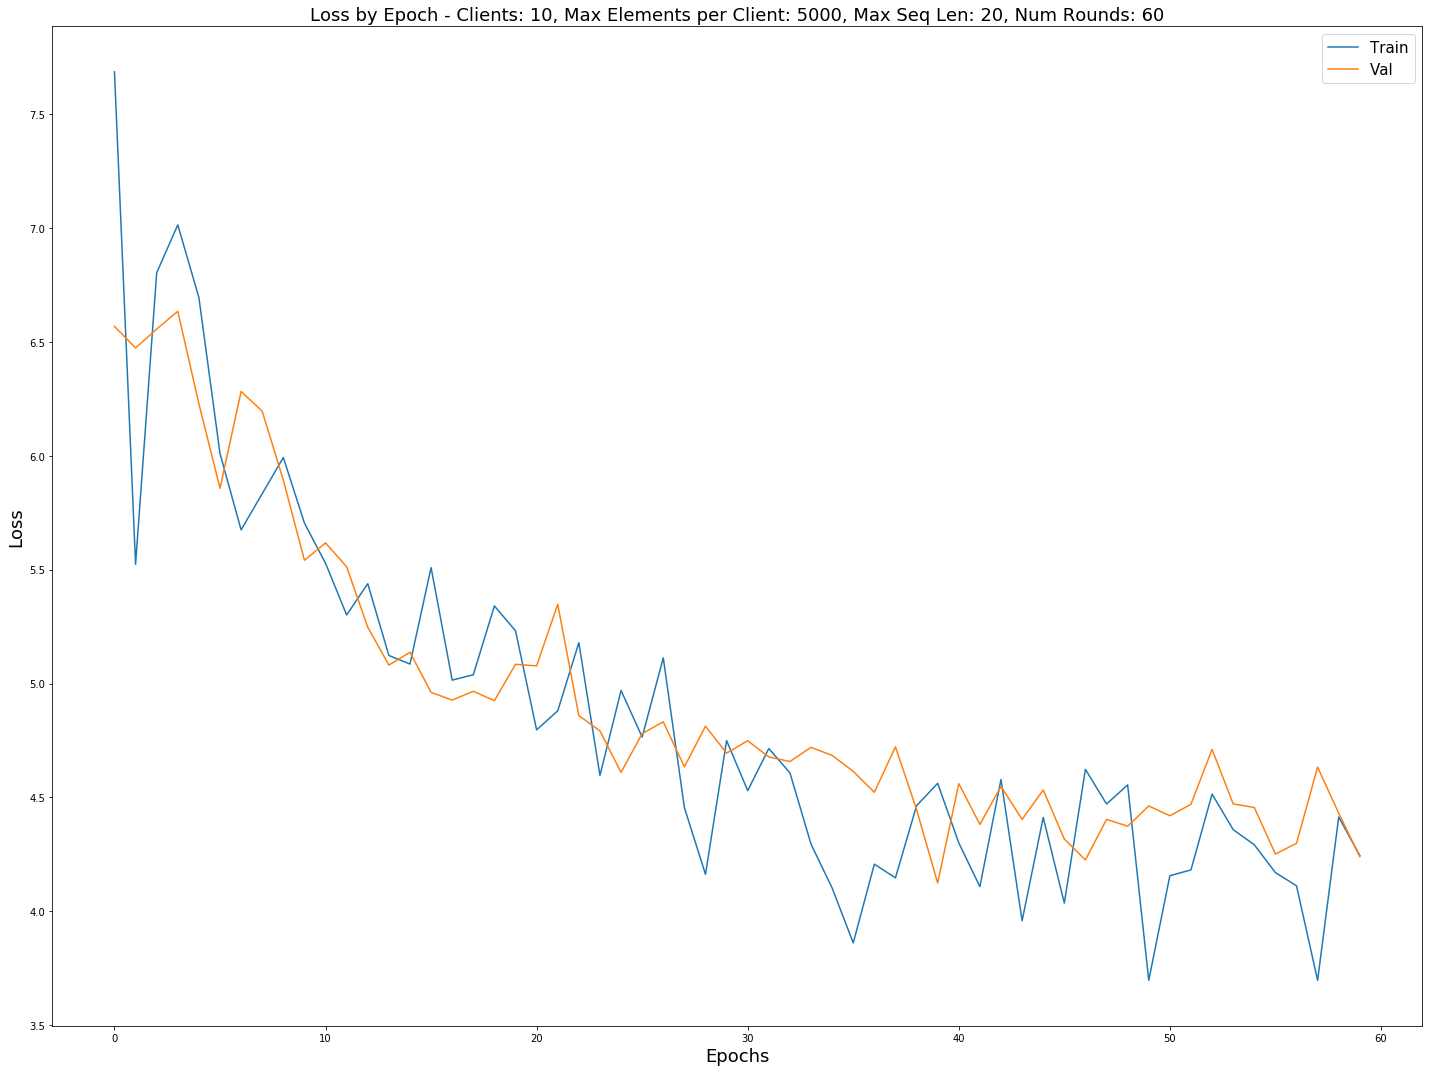

In [19]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Loss by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Loss by Epoch.png')
plt.show()

### Pload Train and Validation Accuracy

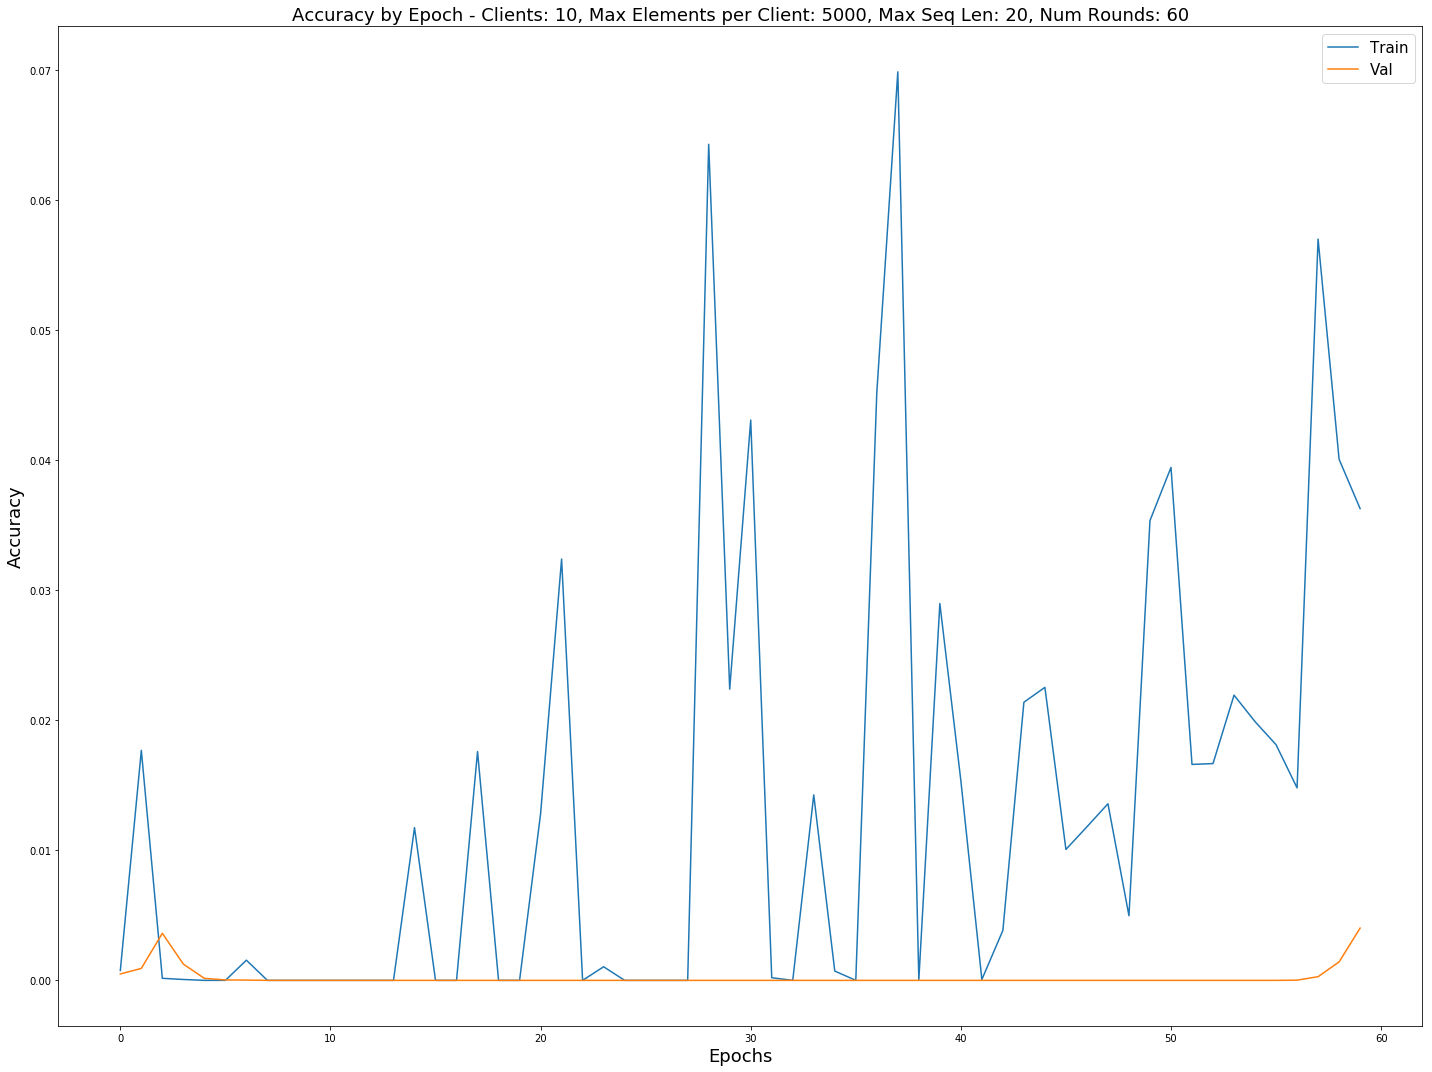

In [20]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Accuracy by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Accuracy by Epoch.png')
plt.show()

### Load Train Sample Stats

In [21]:
examples = np.load(SAV + 'num_examples.npy')
tokens = np.load(SAV + 'num_tokens.npy')
tokens_no_oov = np.load(SAV + 'num_tokens_no_oov.npy')

### Compute Train Sample Means and Standard Deviations

In [22]:
train_sample_stats = ['Examples', 'Tokens', 'Tokens No OOV']
means = [np.mean(examples), np.mean(tokens), np.mean(tokens_no_oov)]
stdvs = [np.std(examples), np.std(tokens), np.std(tokens_no_oov)]

### Plot Train Sample Stats

<Figure size 432x288 with 0 Axes>

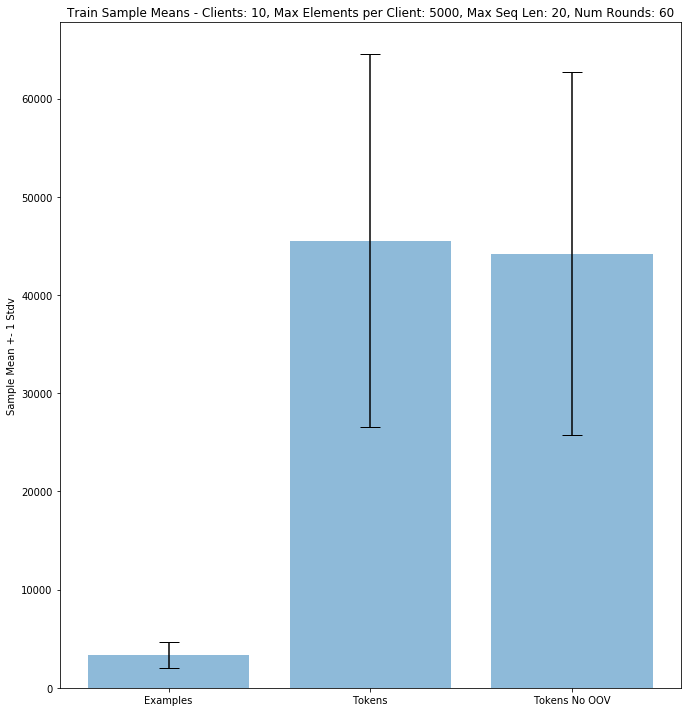

In [23]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
x_pos = np.arange(len(train_sample_stats))
ax.bar(x_pos, means, yerr=stdvs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Sample Mean +- 1 Stdv')
ax.set_xticks(x_pos)
ax.set_xticklabels(train_sample_stats)
ax.set_title('Train Sample Means - {}'.format(round_config))
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Means.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

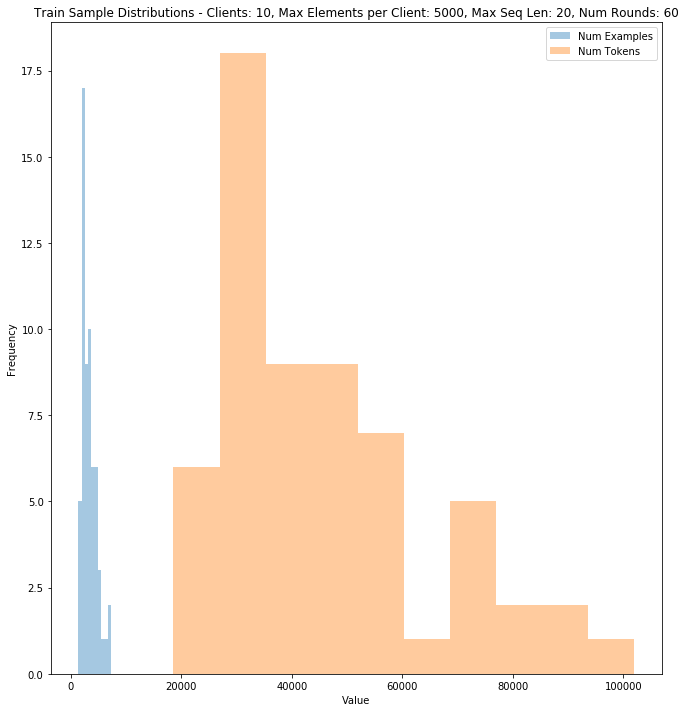

In [24]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.4, label='Num Examples')
plt.hist(tokens, alpha=0.4, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distributions - {}'.format(round_config))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Distributions.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

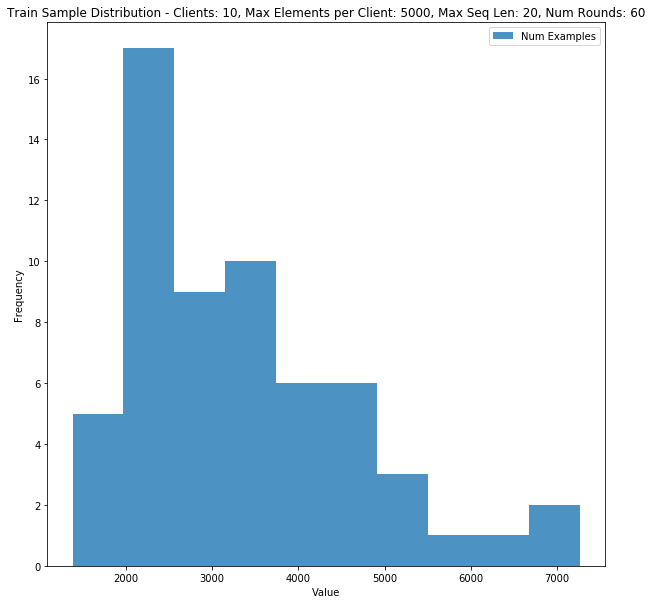

In [25]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.8, label='Num Examples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

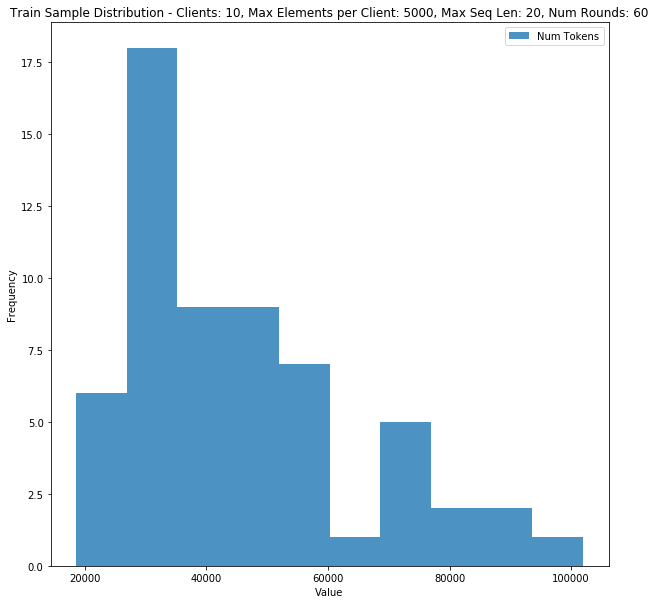

In [26]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens, alpha=0.8, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

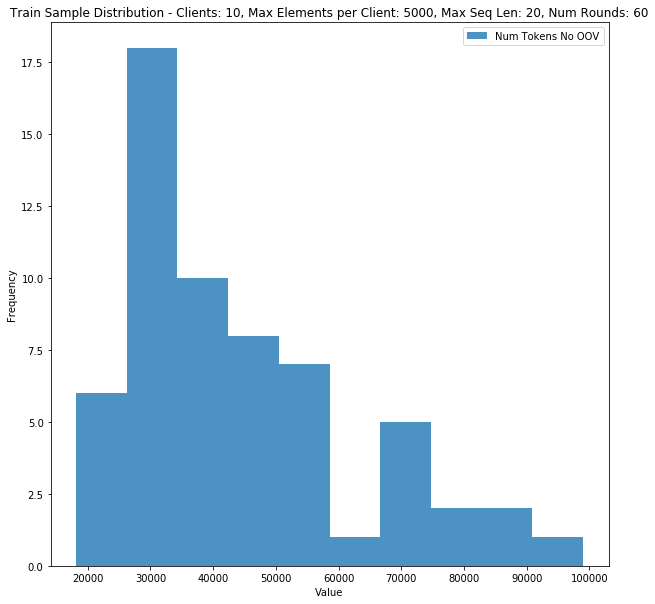

In [27]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens_no_oov, alpha=0.8, label='Num Tokens No OOV')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()